# Cisco

In [181]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import community as community_louvain
from networkx.algorithms import community as nx_community
from networkx.algorithms.community import quality
from networkx.algorithms.community import partition_quality
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics


## Load Cisco Dataset

**Undirected graph construction:**  

Following the preprocessing described in the paper, the official loader aggregates all directed, port-labeled communications between two hosts and collapses them into a **single undirected edge**.  

This matches the setup used by the authors, as community-detection algorithms such as Louvain assume an undirected graph.  
We therefore load g21 directly in this non-directional form before running any analysis.



In [182]:
import sys, gzip
from os import listdir
import numpy as np
from collections import defaultdict, Counter

######  Reading related.

# Expects each line (tab separated columns): graph-id, node1, node2,
# then csv of port info.
def read_edges_with_ports_to_stats(edges_file,
                                   wload_to_graph=None,  wload_to_port_info=None,
                                   wload_to_directed_longevity=None):
    if wload_to_graph is None:  # Otherwise, add to existing graph
        wload_to_graph = {}
    if wload_to_port_info is None:  # Otherwise, add to existing graph
        wload_to_port_info = {}
    directed_longevity = defaultdict(Counter)
    port_to_freq = Counter()
    # Assume gzip file.
    with gzip.open(edges_file, mode='rt') as fopen: # open in rt=read-text mode
        for line in fopen:
            if line.startswith('#'): # skip comment lines
                continue
            parts = line.split()
            if len(parts) < 3:
                continue
            wload_id = parts[0]
            v1 = parts[1]  # node1, consumer / client
            v2 = parts[2]
            
            if wload_id not in wload_to_graph:
                wload_to_graph[ wload_id ] = defaultdict(Counter)
            v_to_u = wload_to_graph[wload_id]
            port_info = parts[3]
            ports = port_info.split( ',' )
            stats = wload_to_port_info.get(wload_id, None)
            if stats is None:
                stats = defaultdict(set)
                wload_to_port_info[ wload_id ] = stats

            ports_added = False
            for port_tuple in ports:
                #if 0 and '-' not in port_tuple:
                #    continue
                if 'p' not in port_tuple:
                    continue
                port_part = port_tuple.split('-')[0]
                if port_part == '':
                    continue
                port_to_freq[port_part] += 1
                stats[port_part].add((v1, v2))
                ports_added = True
                directed_longevity[wload_id][(v1, v2, port_part)] = 1
                
            if ports_added:
                v_to_u[v1][v2] += 1
                v_to_u[v2][v1] += 1
        
    pairs = [(x[0], x[1]) for x in port_to_freq.items()]
    pairs.sort(key=lambda x: - x[1]) # descending
    
    #top=5
    #print('\n# top %d most common ports: %s' % (top, str(pairs[:top])))
    
    if wload_to_directed_longevity is None:
        wload_to_directed_longevity  = directed_longevity
    else:
        for wload, triples in directed_longevity.items():
            for trip in triples:
                wload_to_directed_longevity[wload][trip] += 1
    
    return wload_to_graph, wload_to_port_info, wload_to_directed_longevity

###

# Read and aggregate from possibly multiple edge files.
def read_edges_with_ports_to_stats_multiple_files(path, maxnum=None, print_it=0):
    wload_to_gr = {} # map workload or specific graph, eg 'g1', to its graph of edges
    wload_to_stats = {} # representation by ports first.
    
    # For each file, a directed port-differentiated edges appears in,
    # this goes up by 1 (persistence or longevity of an edge).
    wload_to_directed_longevity = defaultdict(Counter)
    
    print( '\n# reading multiple files.. path is:', path)
    marker = 'gz' # or 'edge' 
    names_only = [f for f in listdir(path) if marker in f   ]
    fnames = [path + '/' + f for f in listdir(path) if marker in f   ] # includes path
    if len(fnames) == 0: # go one level deeper
        dirs = [path + '/' + fdir for fdir in listdir(path) if 'dir' in f   ]
        fnames = []
        names_only = []
        i = 0
        for fdir in dirs:
            i += 1
            fnames += [fdir + '/' + f for f in listdir(fdir) if marker in f  ]
            names_only += [f for f in listdir(fdir) if marker in f  ]
            #if i >= 2: # if we stop at 2 on 20 graphs, this is day 1 and day 2
            #    break

    if len(fnames) == 0: # go one level deeper
        print("\n# No edge files found..\n")
        return {}, {}, {}
    
    fnames.sort()
    if maxnum is not None:
        fnames = fnames[:maxnum]

    if len(names_only) < 10:
        print('\n# All edge file names are:\n%s' % (names_only))
    else:
        print('\n# Some edge file names are:\n%s ...' % (names_only[:10]))

    print('\n# Num files to process: %d, 1st few are:%s\n' % (len(fnames), fnames[:10]))
    
    i = 0
    for fname in fnames:
        i += 1
        if print_it:
            print( '\n# %d. Reading from fname %s' % (i,  fname))
        sys.stdout.flush()
        wload_to_gr, wload_to_stats, wload_to_directed_longevity = read_edges_with_ports_to_stats(
            fname, wload_to_graph=wload_to_gr, wload_to_port_info=wload_to_stats,
            wload_to_directed_longevity=wload_to_directed_longevity)
        sizes = ([len(x) for x in wload_to_gr.values()])
        if print_it:
            print('\n# numgraphs read=%d, min nodes=%d, mean=%.1f, med=%.1f, max=%.1f\n' % (
                len(sizes), np.min(sizes), np.mean(sizes), np.median(sizes), np.max(sizes)))
    print('\n# Done reading from %d file(s).\n' % i)
    return wload_to_gr, wload_to_stats, wload_to_directed_longevity

#############

# Report on the number of nodes and edges (treated as undirected and
# ignoring ports, directed, and finally directed and port
# differentiated). So if there is an edge u to v and there is another
# edge v to u. Then the number of undirected is 1, the number of
# directed is 2 (both ignore ports).
def report_num_nodes_and_edges(workloads, wload_to_directed_longevity):
    if workloads is None or len(workloads) == 0:
        return
    print('\nGraph, num nodes, undirected edges, directed edges, ' +
          'port-differentiated-directed edges' )
    for w in workloads:
        num_trips = 0 # num directed edges (v1, v2, port)
        udirected = set()
        directed = set()
        outv = set()
        allv = set()
        for trip, count in wload_to_directed_longevity[w].items():
            num_trips += 1
            u, v = trip[0], trip[1]
            directed.add((u, v))
            if u <= v:
                udirected.add((u, v))
            else:
                udirected.add((v, u))
            outv.add(u)
            allv.add(u)
            allv.add(v)
        print('%s %d %d %d %d' % (
            w, len(allv), len(udirected), len(directed), num_trips))
    print('\n')

###############################
#################
# 
#  More statistics reporting.
#

def report_degree_and_port_stats(graphs, stats):
    # Sort by number of nodes..
    pairs = [(x[0], len(x[1])) for x in graphs.items()]
    pairs.sort(key=lambda x: -x[1]) # descending
    i = 0
    for wload, size in pairs:
        i += 1
        num_ports = len( stats[wload] )
        report_node_by_degree(
            stats[wload], wload, len(graphs[wload]))
            
def report_node_by_degree(
        port_to_list, wload, num_nodes=0):
    # For computing number of nodes providing one or more service
    # ports.
    provider_to = defaultdict(set)
    # Same for client of (or consumer of.
    consumer_of = defaultdict(set)
    dir_graph  = defaultdict(set) # directed graph
    undir_graph  = defaultdict(Counter) # undirected graph

    # by_provided = defaultdict(dict)
    by_consumed = defaultdict(dict)
          
    uedges = set()
    all_nodes = set()
    numports2 = 0
    for port, vlist in port_to_list.items():
        if len(vlist) > 1:
          numports2 += 1
        for v1, v2 in vlist:
          all_nodes.add(v1)
          all_nodes.add(v2)
            
          provider_to[v2].add(port)
          consumer_of[v1].add(port)

          #if port not in by_provided[v2]:
          #  by_provided[v2][port] = set()
          if port not in by_consumed[v1]:
            by_consumed[v1][port] = set()
          
          # by_provided[v2][port].add(v1)
          by_consumed[v1][port].add(v2)
          
          dir_graph[v1].add(v2) # directed graph
          if v1 < v2:
              uedges.add((v1, v2)) 
          else:
              uedges.add((v2, v1))
          undir_graph[v1][v2]=1
          undir_graph[v2][v1]=1

    numports = len(port_to_list)
    two_way = 0 # directed 2-cycles (u to v and v to u)
    nself = 0 # any self-arcs?
    for u, neibs in dir_graph.items():
        for v in neibs:
            if u == v:
                nself += 1
                continue
            if v in dir_graph:
                if u in dir_graph[v]:
                    two_way += 1

    inAndOutAtLeastOne = 0
    for node in provider_to:
        if node in consumer_of:
            inAndOutAtLeastOne += 1

    # Num directed and undirected edges
    numde = sum( [len(x[1]) for x in dir_graph.items() ]  )
    numue =  len( uedges  )  # undirected

    udegs = [len(x) for x in undir_graph.values() ]
    medd = np.median(udegs)
    maxd = np.max(udegs)
    d2 = len(list(filter(lambda x: x > 1, udegs)))
        
    nump = len(provider_to) # providing at least one port
    numc = len(consumer_of) # consuming at least one port
        
    thresh=1
    ps = [len(x) for x in provider_to.values() ]
    # ps = [x[1] for x in pairsp] # for median and max
    medp = np.median(ps)
    maxp = np.max(ps)
    nump2 = len(list(filter(lambda x: x > thresh, ps)))
        
    pairsc = [(x[0], len(x[1])) for x in consumer_of.items() ]
    cs = [x[1] for x in pairsc] # for median and max
    medc = np.median(cs)
    maxc = np.max(cs)
    numc2 = len(list(filter(lambda x: x[1] > thresh, pairsc)))

    print('\nGraph=%s num nodes=%d, num undirected edges=%d' % (wload, len(all_nodes), numue))
    print('(undirected) num nodes with degree 2+=%d, median degree=%d, max degree=%d' % (
        d2, medd, maxd))
    print('Num. of (unique service) ports in graph =%d, on 2+ edges=%d' % (numports, numports2))
    print('Num. nodes providing a port=%d, 2+ ports=%d median=%d max=%d' % (
        nump, nump2, medp, maxp))
    print('Num. nodes client of a port=%d, 2+ ports=%d median=%d max=%d' % (
        numc, numc2, medc, maxc))
    print('Num. nodes with positive indegree and outdegree = %d' % (inAndOutAtLeastOne))
    print('Num. of self-arcs: %d' % (nself))
    print('Num. directed edges: %d' % numde)
    print('Num. of directed 2-cycles: %d\n' % (two_way))

In [183]:
def load_cisco_graph_official(path, graph_id="g21", maxnum=None, print_it=0):
    wload_to_gr, wload_to_stats, wload_to_directed_longevity = read_edges_with_ports_to_stats_multiple_files(
        path, maxnum=maxnum, print_it=print_it
    )

    if graph_id not in wload_to_gr:
        raise ValueError(f"Graph id {graph_id} didn't found in {path}. "
                         f"Graph: {list(wload_to_gr.keys())}")

    
    adj = wload_to_gr[graph_id]

    
    G = nx.Graph()
    for v1, neighs in adj.items():
        for v2 in neighs.keys():
            if v1 == v2:
                continue
            G.add_edge(v1, v2)

    return G, wload_to_stats[graph_id], wload_to_directed_longevity[graph_id]

### Dataset Overview
The dataset contains two main graph categories, g20 and g21, which differ both in origin and purpose.

**g20 – Real Cisco Network Data:**
- Derived from real enterprise traffic logs.
- Large, noisy, and dominated by common service ports.
- No ground truth is available for node groupings.
- Used mainly to study algorithm behavior in realistic conditions.

**g21 – Synthetic Dataset With Ground Truth**
- Artificially generated by the authors.
- Much smaller and easier to analyze.
- Includes a provided ground truth partition of functional groups.
- Enables direct evaluation of community-detection accuracy.

**Choice of Dataset:**
Given these properties, we selected g21 for our experiments because its size and ground truth make it suitable for validating whether community-detection algorithms correctly reconstruct known structures.


In [184]:
g21_dir = "Cisco_22_networks/dir_g21_small_workload_with_gt/dir_includes_packets_and_other_nodes"
#g20_dir = "Cisco_22_networks/dir_20_graphs/dir_day1"

In [185]:
G, stats_g21, longevity_g21 = load_cisco_graph_official(g21_dir, graph_id="g21")

print("Node:", G.number_of_nodes())
print("Edges:", G.number_of_edges())



# reading multiple files.. path is: Cisco_22_networks/dir_g21_small_workload_with_gt/dir_includes_packets_and_other_nodes

# Some edge file names are:
['edges_to_ports_202202130300.anon.txt.gz', 'edges_to_ports_202202131400.anon.txt.gz', 'edges_to_ports_202202101800.anon.txt.gz', 'edges_to_ports_202202102100.anon.txt.gz', 'edges_to_ports_202202131000.anon.txt.gz', 'edges_to_ports_202202130700.anon.txt.gz', 'edges_to_ports_202202122300.anon.txt.gz', 'edges_to_ports_202202110100.anon.txt.gz', 'edges_to_ports_202202111600.anon.txt.gz', 'edges_to_ports_202202111200.anon.txt.gz'] ...

# Num files to process: 96, 1st few are:['Cisco_22_networks/dir_g21_small_workload_with_gt/dir_includes_packets_and_other_nodes/edges_to_ports_202202100000.anon.txt.gz', 'Cisco_22_networks/dir_g21_small_workload_with_gt/dir_includes_packets_and_other_nodes/edges_to_ports_202202100100.anon.txt.gz', 'Cisco_22_networks/dir_g21_small_workload_with_gt/dir_includes_packets_and_other_nodes/edges_to_ports_20220210020

## 1. Preliminary Statistics & Analysis

**What this graph represents:**  
Graph **g21** from the Cisco dataset, where nodes correspond to **network hosts** (clients or servers) and edges represent **observed communication events** between them during the data collection window.  


In [186]:
print("=== Basic Graph Statistics ===")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Density: {nx.density(G):.6f}")
print(f"Is connected: {nx.is_connected(G)}")
print(f"Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")
print(f"Average clustering coefficient: {nx.average_clustering(G):.4f}")

try:
    print(f"Average shortest path length: {nx.average_shortest_path_length(G):.4f}")
except:
    print("Average shortest path length: Cannot compute (graph not connected)")

=== Basic Graph Statistics ===
Number of nodes: 317
Number of edges: 1689
Density: 0.033722
Is connected: False
Average degree: 10.66
Average clustering coefficient: 0.1855
Average shortest path length: Cannot compute (graph not connected)


### Degree Distribution

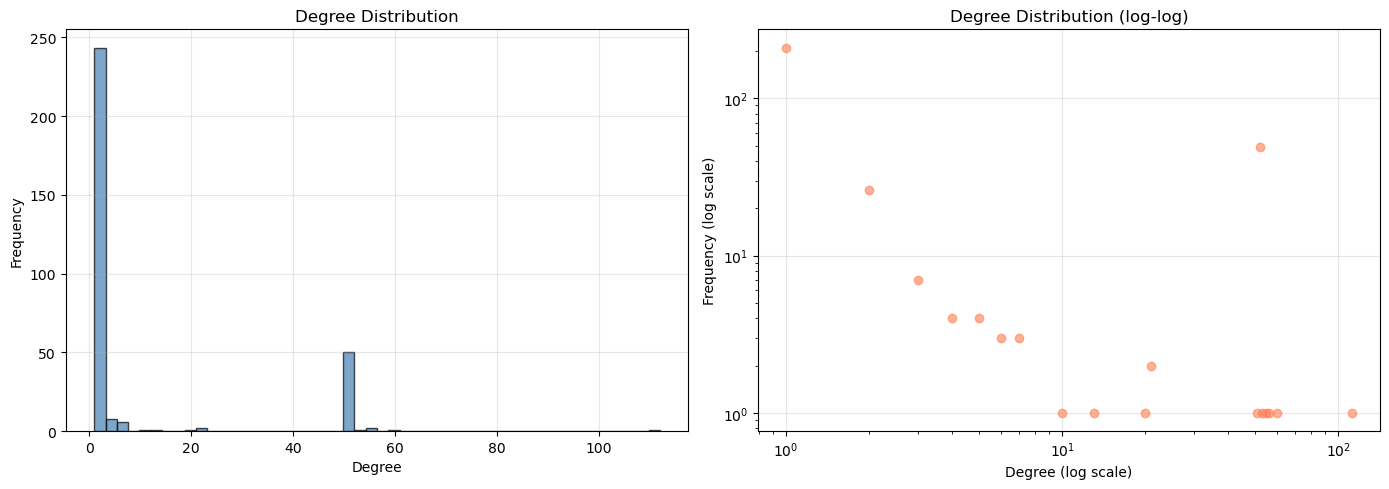

Min degree: 1
Max degree: 112
Median degree: 1.00


In [187]:
degrees = [G.degree(n) for n in G.nodes()]
degree_counts = Counter(degrees)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution')
axes[0].grid(True, alpha=0.3)

degree_sorted = sorted(degree_counts.items())
x_vals = [d[0] for d in degree_sorted if d[0] > 0]
y_vals = [d[1] for d in degree_sorted if d[0] > 0]
axes[1].loglog(x_vals, y_vals, 'o', alpha=0.6, color='coral')
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution (log-log)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Median degree: {np.median(degrees):.2f}")

### Centrality Measures

In [188]:
degree_centrality = nx.degree_centrality(G)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Degree Centrality ===")
for node, cent in top_degree:
    print(f"Node {node}: {cent:.4f}")

=== Top 10 Nodes by Degree Centrality ===
Node 102: 0.3544
Node 59: 0.1899
Node 15: 0.1772
Node 16: 0.1741
Node 49: 0.1677
Node 20: 0.1646
Node 23: 0.1646
Node 2: 0.1646
Node 24: 0.1646
Node 3: 0.1646


In [189]:
print("Computing betweenness centrality (may take time)...")
betweenness = nx.betweenness_centrality(G, k=min(1000, G.number_of_nodes()))
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Betweenness Centrality ===")
for node, cent in top_betweenness:
    print(f"Node {node}: {cent:.4f}")

Computing betweenness centrality (may take time)...
=== Top 10 Nodes by Betweenness Centrality ===
Node 102: 0.2286
Node 54: 0.0396
Node 64: 0.0366
Node 59: 0.0356
Node 67: 0.0281
Node 89: 0.0184
Node 49: 0.0124
Node 143: 0.0115
Node 103: 0.0058
Node 115: 0.0049


In [190]:
print("Computing closeness centrality...")
closeness = nx.closeness_centrality(G)
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Closeness Centrality ===")
for node, cent in top_closeness:
    print(f"Node {node}: {cent:.4f}")

Computing closeness centrality...
=== Top 10 Nodes by Closeness Centrality ===
Node 102: 0.3633
Node 54: 0.2492
Node 64: 0.2476
Node 67: 0.2245
Node 103: 0.2239
Node 68: 0.2194
Node 75: 0.2194
Node 110: 0.2194
Node 265: 0.2098
Node 266: 0.2098


In [191]:
print("Computing eigenvector centrality...")
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
top_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Eigenvector Centrality ===")
for node, cent in top_eigenvector:
    print(f"Node {node}: {cent:.4f}")

Computing eigenvector centrality...
=== Top 10 Nodes by Eigenvector Centrality ===
Node 15: 0.1378
Node 49: 0.1375
Node 20: 0.1374
Node 23: 0.1374
Node 2: 0.1374
Node 24: 0.1374
Node 3: 0.1374
Node 11: 0.1374
Node 44: 0.1374
Node 14: 0.1374


### Centrality Comparison

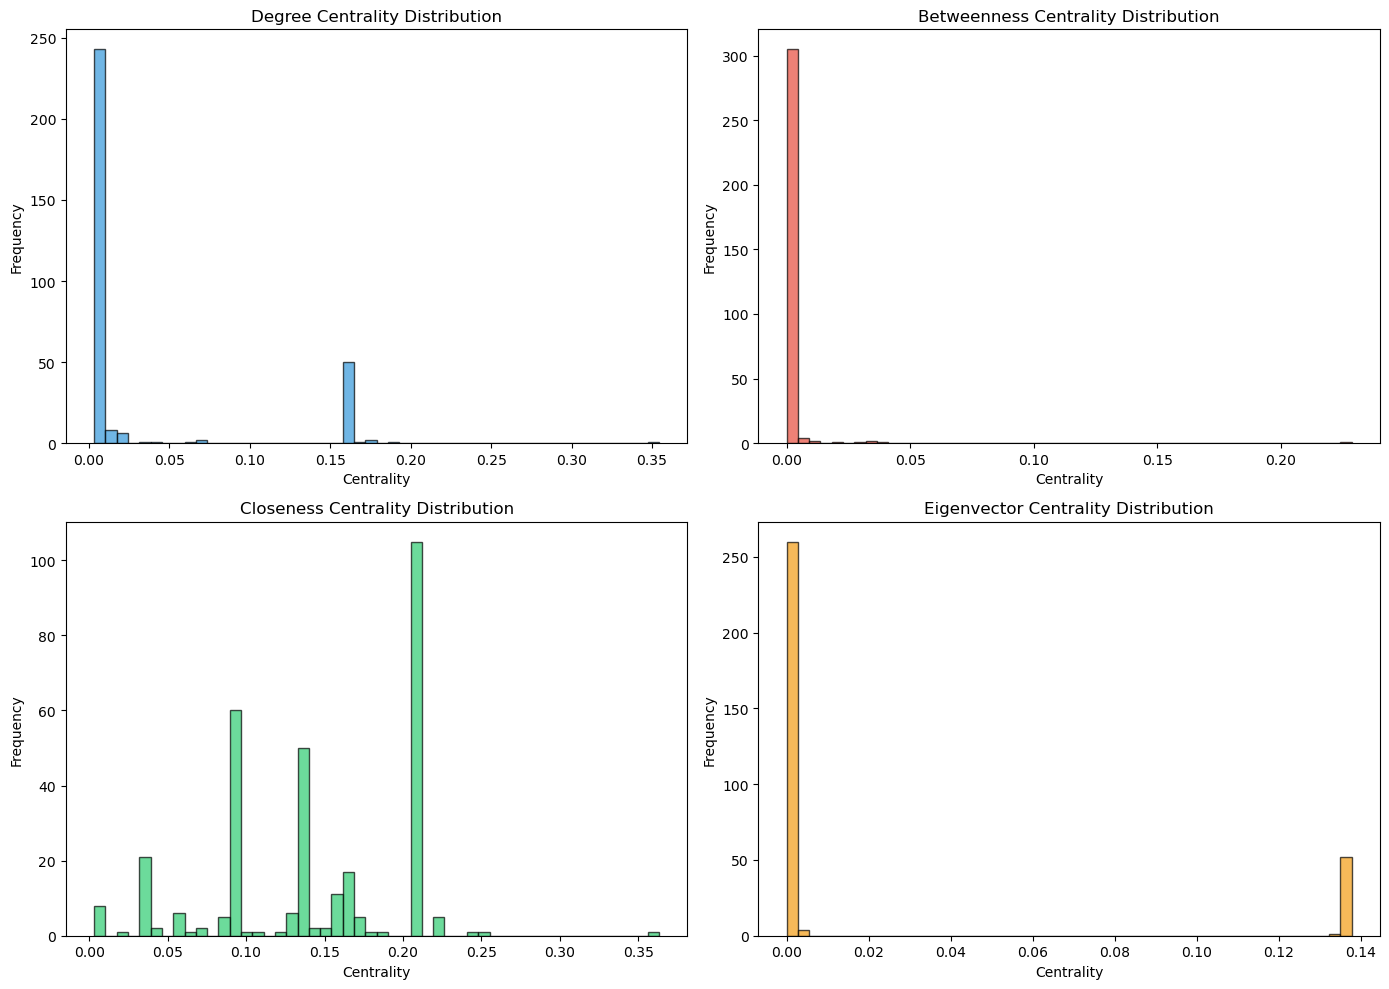

In [192]:
centrality_df = pd.DataFrame({
    'Degree': list(degree_centrality.values()),
    'Betweenness': list(betweenness.values()),
    'Closeness': list(closeness.values()),
    'Eigenvector': list(eigenvector.values())
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

axes[0, 0].hist(centrality_df['Degree'], bins=50, edgecolor='black', alpha=0.7, color=colors[0])
axes[0, 0].set_title('Degree Centrality Distribution')
axes[0, 0].set_xlabel('Centrality')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(centrality_df['Betweenness'], bins=50, edgecolor='black', alpha=0.7, color=colors[1])
axes[0, 1].set_title('Betweenness Centrality Distribution')
axes[0, 1].set_xlabel('Centrality')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(centrality_df['Closeness'], bins=50, edgecolor='black', alpha=0.7, color=colors[2])
axes[1, 0].set_title('Closeness Centrality Distribution')
axes[1, 0].set_xlabel('Centrality')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(centrality_df['Eigenvector'], bins=50, edgecolor='black', alpha=0.7, color=colors[3])
axes[1, 1].set_title('Eigenvector Centrality Distribution')
axes[1, 1].set_xlabel('Centrality')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Ground Truth Loading

**Purpose of this step:**  
To evaluate the performance of community-detection and centrality-based algorithms, we load the **ground truth functional groups** provided for graph **g21**.  
Each line in the `groupings.gt.txt` file corresponds to a predefined community, listing the nodes that belong to that functional group.


In [193]:
gt_groups = []
gt_path = "Cisco_22_networks/dir_g21_small_workload_with_gt/groupings.gt.txt"
with open(gt_path, "r") as f:
    for line in f:
        line = line.strip()
        if not line or line.startswith("#"):
            continue

        nodes = [n.strip() for n in line.split(",") if n.strip()]
        gt_groups.append(nodes)

print("Number of groups of GT:", len(gt_groups))
print("First 5 comunity of GT:", gt_groups[:5])

Number of groups of GT: 23
First 5 comunity of GT: [['2'], ['6'], ['49'], ['14'], ['48', '7']]


In [194]:
node_to_gt = {}

for cid, group in enumerate(gt_groups):
    for node in group:
        node_to_gt[node] = cid

print("(node -> comunity GT):")
list(node_to_gt.items())[:10]

(node -> comunity GT):


[('2', 0),
 ('6', 1),
 ('49', 2),
 ('14', 3),
 ('48', 4),
 ('7', 4),
 ('11', 5),
 ('31', 5),
 ('21', 6),
 ('34', 6)]

In [195]:
print("Graph nodes:", list(G.nodes())[:50])
print("Total nodes:", G.number_of_nodes())
print("GT nodes:", list(node_to_gt.keys())[:50])

Graph nodes: ['20', '23', '2', '24', '3', '11', '44', '14', '38', '7', '21', '29', '16', '31', '12', '8', '36', '34', '19', '32', '50', '22', '43', '1', '53', '47', '6', '49', '40', '13', '17', '37', '26', '30', '25', '4', '9', '57', '48', '5', '39', '10', '51', '46', '15', '42', '33', '35', '41', '27']
Total nodes: 317
GT nodes: ['2', '6', '49', '14', '48', '7', '11', '31', '21', '34', '24', '19', '13', '29', '57', '53', '42', '35', '27', '41', '9', '8', '38', '5', '44', '28', '46', '30', '4', '1', '47', '10', '32', '3', '12', '25', '15', '16', '26', '20', '22', '18', '37', '50', '33', '45', '51', '43', '39', '36']


## 2. Community Detection

### Algorithm 1: Louvain Method

In [196]:
partition_louvain = community_louvain.best_partition(G)

communities_louvain = {}
for node, comm_id in partition_louvain.items():
    if comm_id not in communities_louvain:
        communities_louvain[comm_id] = []
    communities_louvain[comm_id].append(node)

print(f"=== Louvain Method ===")
print(f"Number of communities: {len(communities_louvain)}")
print(f"Modularity: {community_louvain.modularity(partition_louvain, G):.4f}")

community_sizes = [len(comm) for comm in communities_louvain.values()]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")

=== Louvain Method ===
Number of communities: 9
Modularity: 0.3149
Largest community size: 106
Smallest community size: 2
Average community size: 35.22
Median community size: 22.00


### Algorithm 2: Label Propagation

In [197]:
communities_greedy = list(nx_community.greedy_modularity_communities(G))

partition_greedy = {}
for idx, comm in enumerate(communities_greedy):
    for node in comm:
        partition_greedy[node] = idx


print(f"=== Greedy Modularity ===")
print(f"Number of communities: {len(communities_greedy)}")
print(f"Modularity: {nx_community.modularity(G, communities_greedy):.4f}")

community_sizes = [len(comm) for comm in communities_greedy]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")


=== Greedy Modularity ===
Number of communities: 8
Modularity: 0.3096
Largest community size: 121
Smallest community size: 2
Average community size: 39.62
Median community size: 29.00


### Algorithm 3: Greedy Modularity

In [198]:
communities_lp = list(nx_community.label_propagation_communities(G))

partition_lp = {}
for idx, comm in enumerate(communities_lp):
    for node in comm:
        partition_lp[node] = idx

print(f"=== Label Propagation ===")
print(f"Number of communities: {len(communities_lp)}")
print(f"Modularity: {nx_community.modularity(G, communities_lp):.4f}")

community_sizes = [len(comm) for comm in communities_lp]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")

=== Label Propagation ===
Number of communities: 13
Modularity: 0.3075
Largest community size: 107
Smallest community size: 2
Average community size: 24.38
Median community size: 7.00


### Community Visualization on Network

**Visualizing a subgraph sample for clarity**

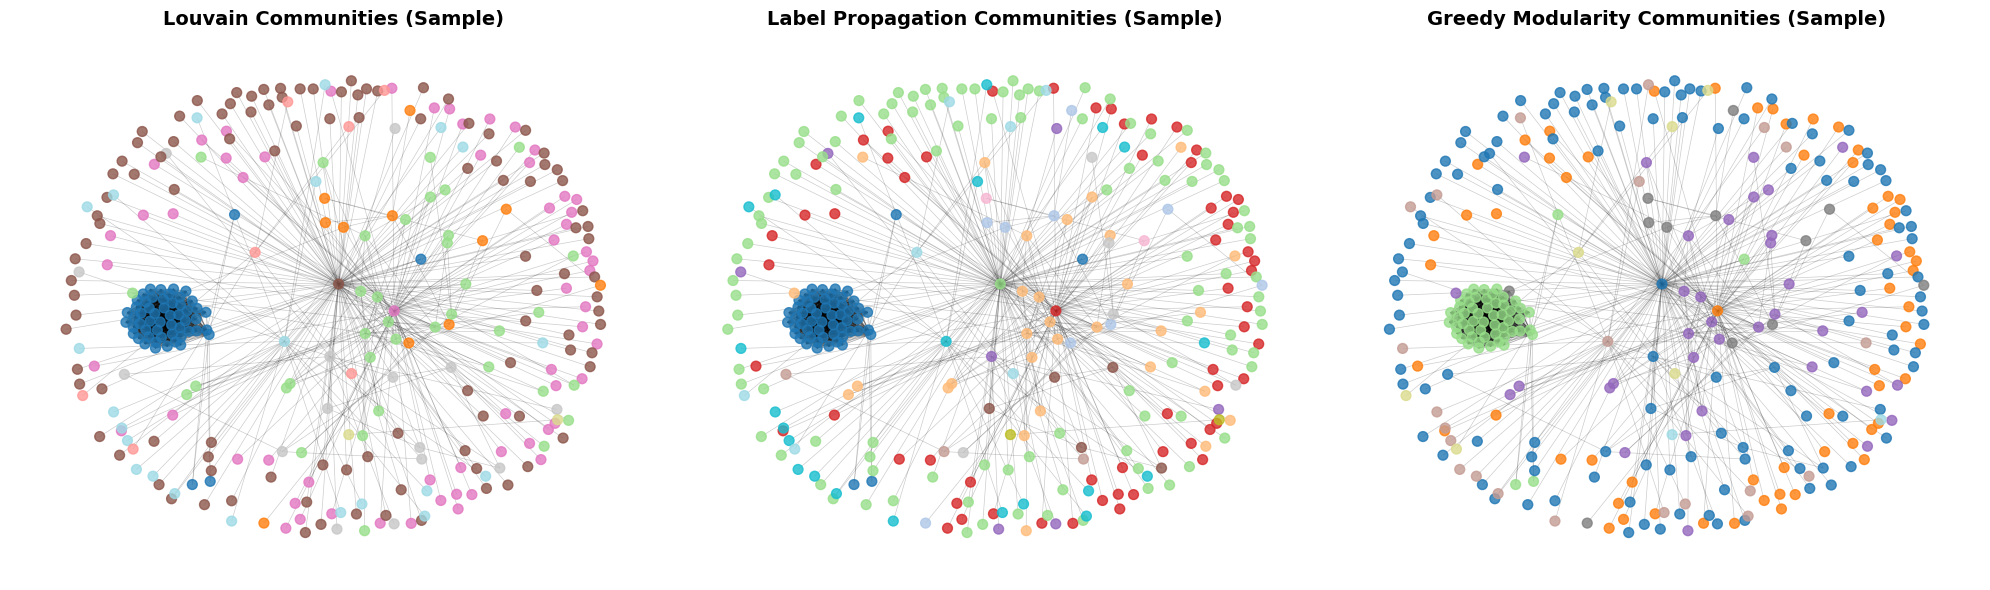

In [199]:
sample_nodes = list(G.nodes())
G_sample = G.subgraph(sample_nodes).copy()

pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

node_colors_louvain = [partition_louvain.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_louvain, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[0])
axes[0].set_title('Louvain Communities (Sample)', fontsize=14, fontweight='bold')
axes[0].axis('off')

node_colors_lp = [partition_lp.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_lp, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[1])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[1])
axes[1].set_title('Label Propagation Communities (Sample)', fontsize=14, fontweight='bold')
axes[1].axis('off')

node_colors_greedy = [partition_greedy.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_greedy, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[2])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[2])
axes[2].set_title('Greedy Modularity Communities (Sample)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Filtering Dominant Ports
**Motivation (based on the evidence shown in the paper):**  

When using the raw version of g21, the authors observe that a small number of ports generate an extremely large fraction of all connections. These dominant ports make the graph overly dense and lead to **low modularity** and **community structures that do not reflect the expected functional groups**.  
This effect is clearly mentioned in the paper, where the authors specifically identify **port 1 (1p6 and 1p17)** as producing a disproportionately high number of edges.


In [200]:
port_freq = Counter()

for port, pairs in stats_g21.items():
    port_freq[port] += len(pairs)
sorted_ports = sorted(port_freq.items(), key=lambda x: x[1], reverse=True)

print("Top 10 most frequent ports:")
for p, f in sorted_ports[:10]:
    print(f"{p}: {f}")

Top 10 most frequent ports:
1p6: 2646
1p17: 1962
3p17: 246
2p17: 171
18p6: 167
6p6: 156
12p6: 114
31p6: 80
8p6: 78
2p6: 77


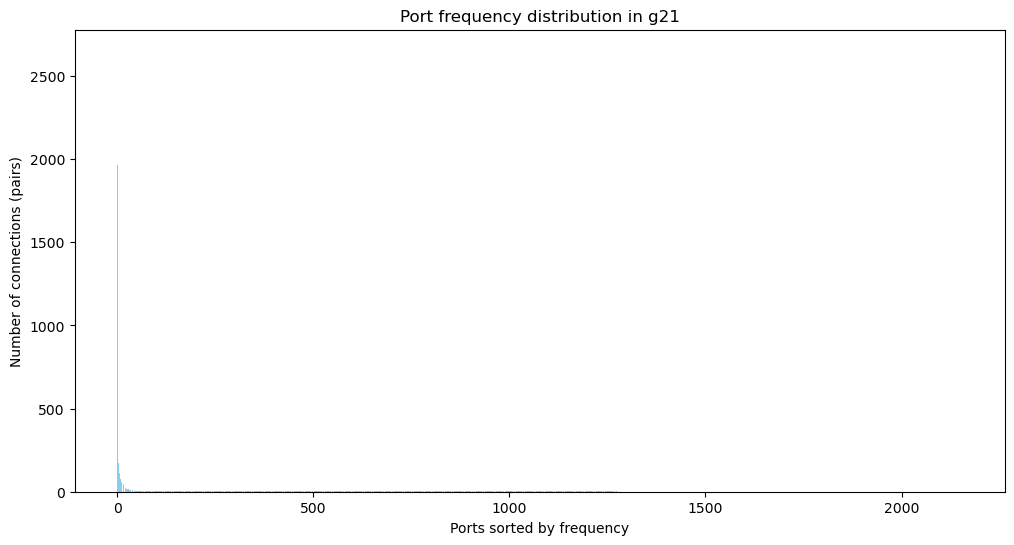

In [201]:
# Histogram showing port frequency distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_ports)), [f for _, f in sorted_ports], color='skyblue')
plt.title("Port frequency distribution in g21")
plt.xlabel("Ports sorted by frequency")
plt.ylabel("Number of connections (pairs)")
plt.show()

In [202]:
top2_ports = [sorted_ports[0][0], sorted_ports[1][0]]
print("Most frequent ports to remove:", top2_ports)

Most frequent ports to remove: ['1p6', '1p17']


In [203]:
import networkx as nx

def build_graph_filtered(stats, remove_ports):
    Gf = nx.Graph()

    for port, pairs in stats.items():
        if port in remove_ports:
            print(port)
            continue  
    
        for u, v in pairs:
            Gf.add_edge(u, v)
    
    return Gf
print()
G_filtered = build_graph_filtered(stats_g21, top2_ports)

print("Nodes in filtered graph:", G_filtered.number_of_nodes())
print("Edges in filtered graph:", G_filtered.number_of_edges())



1p6
1p17
Nodes in filtered graph: 317
Edges in filtered graph: 1045


In [204]:
print("=== Basic Graph Statistics ===")
print(f"Number of nodes: {G_filtered.number_of_nodes()}")
print(f"Number of edges: {G_filtered.number_of_edges()}")
print(f"Density: {nx.density(G_filtered):.6f}")
print(f"Is connected: {nx.is_connected(G_filtered)}")
print(f"Average degree: {sum(dict(G_filtered.degree()).values()) / G_filtered.number_of_nodes():.2f}")
print(f"Average clustering coefficient: {nx.average_clustering(G_filtered):.4f}")

try:
    print(f"Average shortest path length: {nx.average_shortest_path_length(G_filtered):.4f}")
except:
    print("Average shortest path length: Cannot compute (graph not connected)")

=== Basic Graph Statistics ===
Number of nodes: 317
Number of edges: 1045
Density: 0.020864
Is connected: False
Average degree: 6.59
Average clustering coefficient: 0.1547
Average shortest path length: Cannot compute (graph not connected)


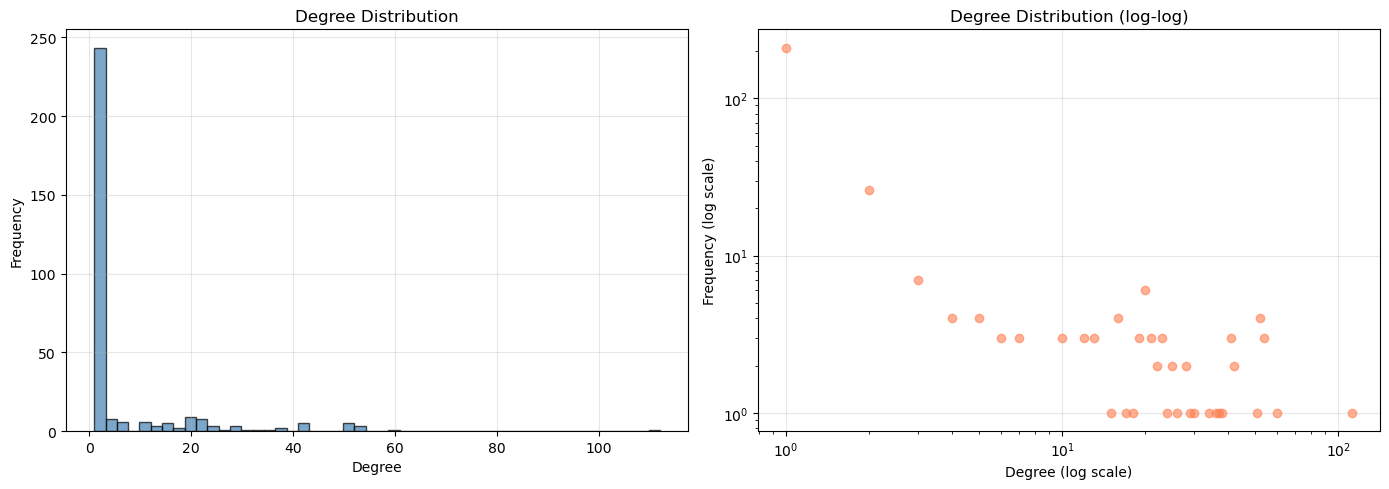

Min degree: 1
Max degree: 112
Median degree: 1.00


In [205]:
degrees = [G_filtered.degree(n) for n in G_filtered.nodes()]
degree_counts = Counter(degrees)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(degrees, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Distribution')
axes[0].grid(True, alpha=0.3)

degree_sorted = sorted(degree_counts.items())
x_vals = [d[0] for d in degree_sorted if d[0] > 0]
y_vals = [d[1] for d in degree_sorted if d[0] > 0]
axes[1].loglog(x_vals, y_vals, 'o', alpha=0.6, color='coral')
axes[1].set_xlabel('Degree (log scale)')
axes[1].set_ylabel('Frequency (log scale)')
axes[1].set_title('Degree Distribution (log-log)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Min degree: {min(degrees)}")
print(f"Max degree: {max(degrees)}")
print(f"Median degree: {np.median(degrees):.2f}")

In [206]:
degree_centrality = nx.degree_centrality(G_filtered)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Degree Centrality ===")
for node, cent in top_degree:
    print(f"Node {node}: {cent:.4f}")

=== Top 10 Nodes by Degree Centrality ===
Node 102: 0.3544
Node 59: 0.1899
Node 17: 0.1709
Node 36: 0.1709
Node 39: 0.1709
Node 40: 0.1646
Node 23: 0.1646
Node 48: 0.1646
Node 7: 0.1646
Node 25: 0.1614


In [207]:
print("Computing betweenness centrality (may take time)...")
betweenness = nx.betweenness_centrality(G_filtered, k=min(1000, G_filtered.number_of_nodes()))
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Betweenness Centrality ===")
for node, cent in top_betweenness:
    print(f"Node {node}: {cent:.4f}")

Computing betweenness centrality (may take time)...
=== Top 10 Nodes by Betweenness Centrality ===
Node 102: 0.2286
Node 54: 0.0396
Node 64: 0.0366
Node 59: 0.0356
Node 67: 0.0281
Node 89: 0.0184
Node 49: 0.0127
Node 143: 0.0115
Node 103: 0.0058
Node 85: 0.0049


In [208]:
print("Computing closeness centrality...")
closeness = nx.closeness_centrality(G_filtered)
top_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Closeness Centrality ===")
for node, cent in top_closeness:
    print(f"Node {node}: {cent:.4f}")

Computing closeness centrality...
=== Top 10 Nodes by Closeness Centrality ===
Node 102: 0.3633
Node 54: 0.2492
Node 64: 0.2476
Node 67: 0.2245
Node 103: 0.2239
Node 68: 0.2194
Node 75: 0.2194
Node 110: 0.2194
Node 290: 0.2098
Node 176: 0.2098


In [209]:
print("Computing eigenvector centrality...")
eigenvector = nx.eigenvector_centrality(G_filtered, max_iter=1000)
top_eigenvector = sorted(eigenvector.items(), key=lambda x: x[1], reverse=True)[:10]

print("=== Top 10 Nodes by Eigenvector Centrality ===")
for node, cent in top_eigenvector:
    print(f"Node {node}: {cent:.4f}")

Computing eigenvector centrality...
=== Top 10 Nodes by Eigenvector Centrality ===
Node 17: 0.2131
Node 36: 0.2131
Node 39: 0.2131
Node 40: 0.2066
Node 23: 0.2066
Node 48: 0.2066
Node 7: 0.2066
Node 25: 0.2016
Node 33: 0.1847
Node 43: 0.1802


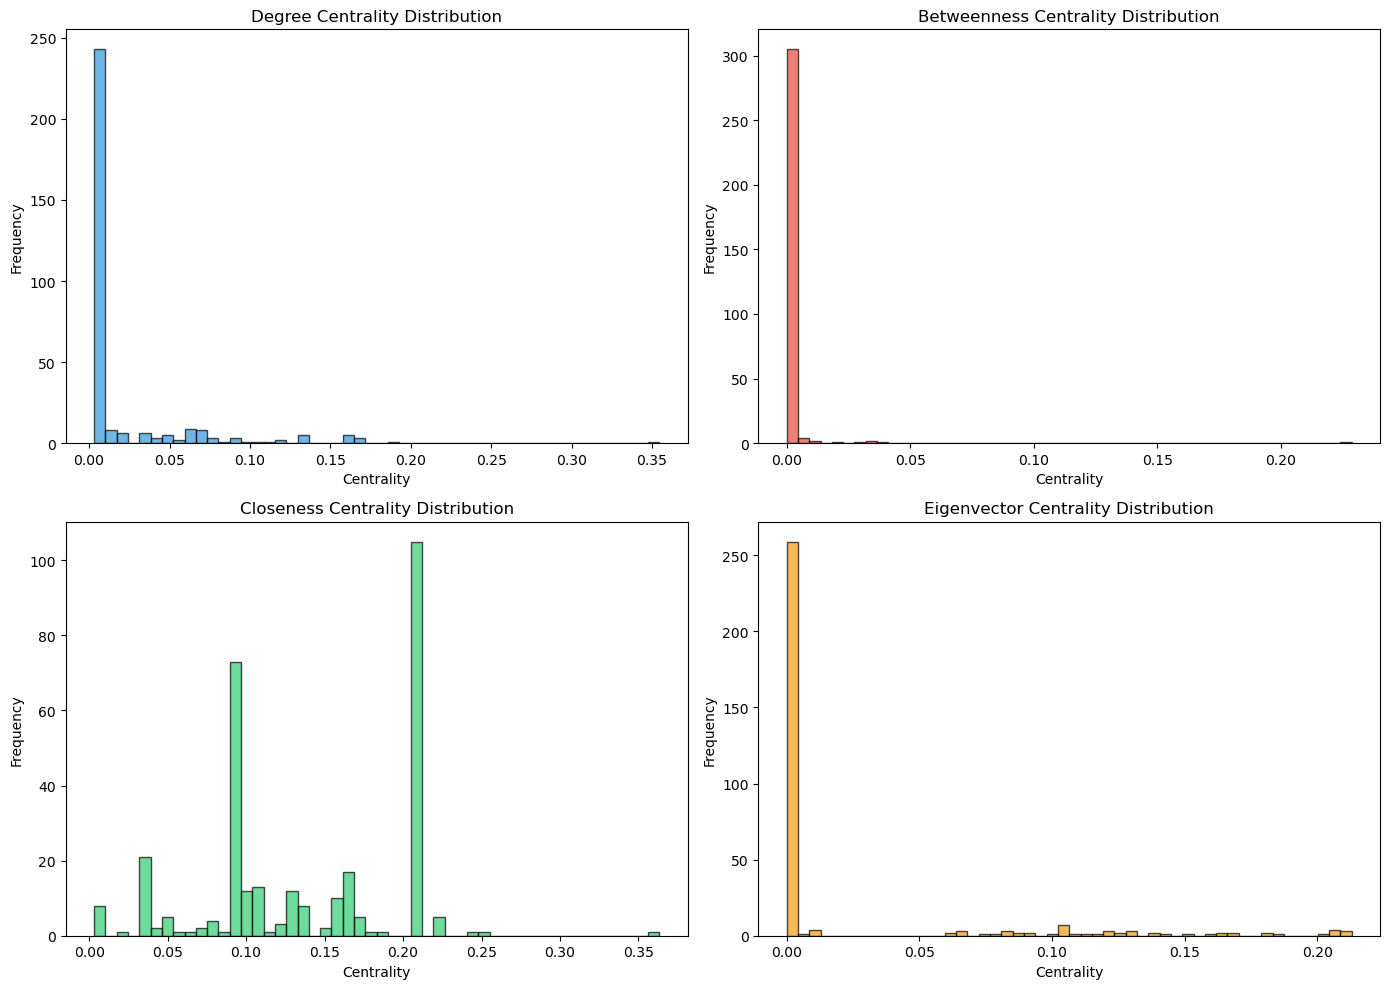

In [210]:
centrality_df = pd.DataFrame({
    'Degree': list(degree_centrality.values()),
    'Betweenness': list(betweenness.values()),
    'Closeness': list(closeness.values()),
    'Eigenvector': list(eigenvector.values())
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

axes[0, 0].hist(centrality_df['Degree'], bins=50, edgecolor='black', alpha=0.7, color=colors[0])
axes[0, 0].set_title('Degree Centrality Distribution')
axes[0, 0].set_xlabel('Centrality')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(centrality_df['Betweenness'], bins=50, edgecolor='black', alpha=0.7, color=colors[1])
axes[0, 1].set_title('Betweenness Centrality Distribution')
axes[0, 1].set_xlabel('Centrality')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(centrality_df['Closeness'], bins=50, edgecolor='black', alpha=0.7, color=colors[2])
axes[1, 0].set_title('Closeness Centrality Distribution')
axes[1, 0].set_xlabel('Centrality')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(centrality_df['Eigenvector'], bins=50, edgecolor='black', alpha=0.7, color=colors[3])
axes[1, 1].set_title('Eigenvector Centrality Distribution')
axes[1, 1].set_xlabel('Centrality')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [211]:
partition_louvain = community_louvain.best_partition(G_filtered)

communities_louvain = {}
for node, comm_id in partition_louvain.items():
    if comm_id not in communities_louvain:
        communities_louvain[comm_id] = []
    communities_louvain[comm_id].append(node)

print(f"=== Louvain Method ===")
print(f"Number of communities: {len(communities_louvain)}")
print(f"Modularity: {community_louvain.modularity(partition_louvain, G_filtered):.4f}")

community_sizes = [len(comm) for comm in communities_louvain.values()]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")

=== Louvain Method ===
Number of communities: 9
Modularity: 0.4693
Largest community size: 106
Smallest community size: 2
Average community size: 35.22
Median community size: 22.00


In [212]:
communities_greedy = list(nx_community.greedy_modularity_communities(G_filtered))

partition_greedy = {}
for idx, comm in enumerate(communities_greedy):
    for node in comm:
        partition_greedy[node] = idx


print(f"=== Greedy Modularity ===")
print(f"Number of communities: {len(communities_greedy)}")
print(f"Modularity: {nx_community.modularity(G_filtered, communities_greedy):.4f}")

community_sizes = [len(comm) for comm in communities_greedy]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")

=== Greedy Modularity ===
Number of communities: 9
Modularity: 0.4693
Largest community size: 106
Smallest community size: 2
Average community size: 35.22
Median community size: 22.00


In [213]:
communities_lp = list(nx_community.label_propagation_communities(G_filtered))

partition_lp = {}
for idx, comm in enumerate(communities_lp):
    for node in comm:
        partition_lp[node] = idx

print(f"=== Label Propagation ===")
print(f"Number of communities: {len(communities_lp)}")
print(f"Modularity: {nx_community.modularity(G_filtered, communities_lp):.4f}")

community_sizes = [len(comm) for comm in communities_lp]
print(f"Largest community size: {max(community_sizes)}")
print(f"Smallest community size: {min(community_sizes)}")
print(f"Average community size: {np.mean(community_sizes):.2f}")
print(f"Median community size: {np.median(community_sizes):.2f}")

=== Label Propagation ===
Number of communities: 15
Modularity: 0.4454
Largest community size: 107
Smallest community size: 2
Average community size: 21.13
Median community size: 7.00


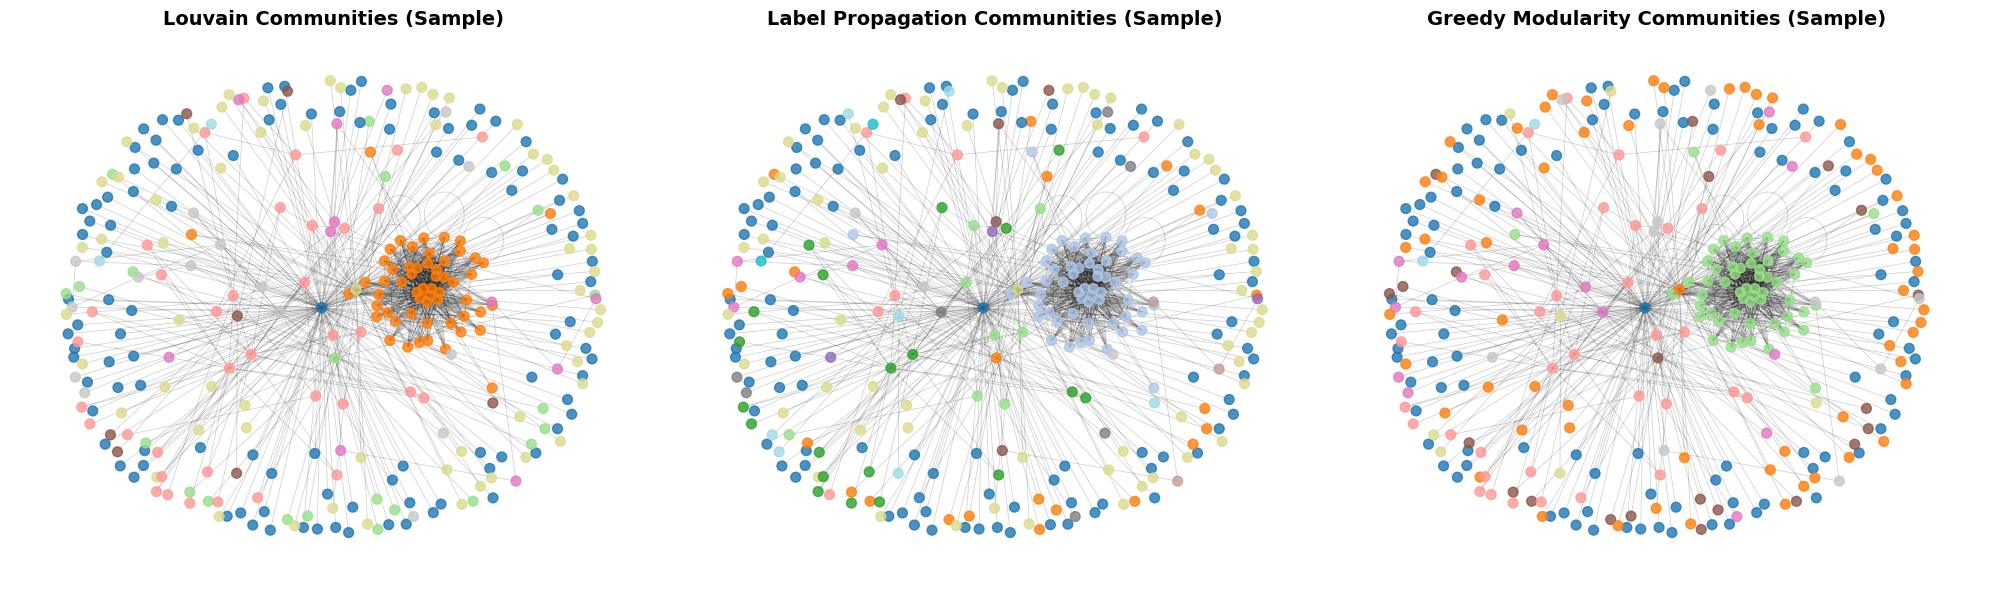

In [214]:
sample_nodes = list(G_filtered.nodes())[:500]
G_sample = G_filtered.subgraph(sample_nodes).copy()

pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

node_colors_louvain = [partition_louvain.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_louvain, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[0])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[0])
axes[0].set_title('Louvain Communities (Sample)', fontsize=14, fontweight='bold')
axes[0].axis('off')

node_colors_lp = [partition_lp.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_lp, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[1])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[1])
axes[1].set_title('Label Propagation Communities (Sample)', fontsize=14, fontweight='bold')
axes[1].axis('off')

node_colors_greedy = [partition_greedy.get(node, 0) for node in G_sample.nodes()]
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors_greedy, node_size=50, 
                       cmap='tab20', alpha=0.8, ax=axes[2])
nx.draw_networkx_edges(G_sample, pos, alpha=0.2, width=0.5, ax=axes[2])
axes[2].set_title('Greedy Modularity Communities (Sample)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

### Community Quality Evaluation Using Ground Truth (Jaccard Overlap)

**Purpose of this step:**
Since graph g21 includes a provided ground truth partition of functional groups, we can quantitatively evaluate how well the detected communities match the expected structure. Following the methodology described in the paper, we measure the **Jaccard overlap** between each community found by Louvain and the most similar ground truth group.

In [215]:
def jaccard(a, b):
    a = set(a)
    b = set(b)
    inter = len(a & b)
    union = len(a | b)
    if union == 0:
        return 0.0
    return inter / union

def average_best_jaccard(found_communities, gt_groups, nodes_to_consider=None,
                         min_size=1, only_if_intersects_gt=True):
    gt_groups = [set(g) for g in gt_groups]
    if nodes_to_consider is not None:
        nodes_to_consider = set(nodes_to_consider)
    
    scores = []
    for comm in found_communities:
        comm = set(comm)
        if nodes_to_consider is not None:
            comm = comm & nodes_to_consider
        if len(comm) < min_size:
            continue
        if only_if_intersects_gt:
            if not any(len(comm & g) > 0 for g in gt_groups):
                continue
        
        best = 0.0
        for g in gt_groups:
            score = jaccard(comm, g)
            if score > best:
                best = score
        scores.append(best)
    
    if not scores:
        return 0.0
    return float(sum(scores)) / len(scores)


In [216]:
partition_louvain = community_louvain.best_partition(G)

communities_louvain = {}
for node, comm_id in partition_louvain.items():
    if comm_id not in communities_louvain:
        communities_louvain[comm_id] = []
    communities_louvain[comm_id].append(node)

In [217]:
found_comms = [set(nodes) for nodes in communities_louvain.values()]
gt_nodes = set().union(*gt_groups)

avg_jaccard = average_best_jaccard(
    found_comms,
    gt_groups,
    nodes_to_consider=None,
    min_size=1,
    only_if_intersects_gt=True
)

print("Average best Jaccard (Louvain vs Ground Truth):", avg_jaccard)

Average best Jaccard (Louvain vs Ground Truth): 0.12717691665060085


### Weighted Graph Construction (Following the Paper’s Approach)

After removing the dominant ports, the authors further improve the quality of the detected communities by constructing a **weighted version** of g21.  
In this weighted graph, edges are assigned weights based on the **ports observed between each pair of nodes** and the **uniqueness** (i.e., frequency) of those ports across the entire graph.  
The paper reports that this weighted representation leads to a clearer community structure and a higher overlap with the ground truth partition.


In [218]:
import networkx as nx
from collections import defaultdict
import math

def build_weighted_from_filtered(G_filtered, stats):

    edge_port_counts = defaultdict(set)
    for port, pairs in stats.items():
        for u, v in pairs:
            if u == v:
                continue
            if u > v:
                u, v = v, u
            if G_filtered.has_edge(u, v):
                edge_port_counts[(u, v)].add(port)

    port_freq = defaultdict(int)
    for (u, v), ports in edge_port_counts.items():
        for p in ports:
            port_freq[p] += 1

    total_pairs = sum(port_freq.values())

    port_idf = {}
    for p, f in port_freq.items():
        port_idf[p] = math.log((total_pairs + 1) / (f + 1))

    Gw = nx.Graph()
    Gw.add_nodes_from(G_filtered.nodes())
    for (u, v), ports in edge_port_counts.items():
        w = sum(port_idf[p] for p in ports)
        Gw.add_edge(u, v, weight=w)

    return Gw

G_weighted = build_weighted_from_filtered(G_filtered, stats_g21)


In [219]:
partition_louvain = community_louvain.best_partition(G_weighted , weight="weight")

communities_louvain = {}
for node, comm_id in partition_louvain.items():
    if comm_id not in communities_louvain:
        communities_louvain[comm_id] = []
    communities_louvain[comm_id].append(node)

In [220]:
found_comms = [set(nodes) for nodes in communities_louvain.values()]
gt_nodes = set().union(*gt_groups)

avg_jaccard = average_best_jaccard(
    found_comms,
    gt_groups,
    nodes_to_consider=None,
    min_size=1,
    only_if_intersects_gt=True
)

print("Average best Jaccard (Louvain vs Ground Truth):", avg_jaccard)

Average best Jaccard (Louvain vs Ground Truth): 0.33714201482479783


In [221]:
def evaluate_communities(G, communities_list, name):
    print(f"\n=== {name} ===")
    
    modularity = nx_community.modularity(G, communities_list)
    print(f"Modularity: {modularity:.4f}")
    
    coverage_val, performance_val = partition_quality(G, communities_list)
    
    total_conductance = 0
    valid_comms = 0
    for comm in communities_list:
        if len(comm) > 1 and len(comm) < G.number_of_nodes():
            total_conductance += nx.conductance(G, comm)
            valid_comms += 1
    avg_conductance = total_conductance / valid_comms if valid_comms > 0 else 0
    print(f"Average Conductance: {avg_conductance:.4f}")
    
    intra_edges = sum(G.subgraph(comm).number_of_edges() for comm in communities_list)
    inter_edges = G.number_of_edges() - intra_edges
    print(f"Intra-community edges: {intra_edges}")
    print(f"Inter-community edges: {inter_edges}")
    
    return {
        'Algorithm': name,
        'Communities': len(communities_list),
        'Modularity': modularity,
        'Coverage': coverage_val,
        'Performance': performance_val,
        'Avg Conductance': avg_conductance
    }

results = []
results.append(evaluate_communities(G_weighted, [set(comm) for comm in communities_louvain.values()], "Louvain"))
results.append(evaluate_communities(G_weighted, communities_lp, "Label Propagation"))
results.append(evaluate_communities(G_weighted, communities_greedy, "Greedy Modularity"))

results_df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(results_df.to_string(index=False))


=== Louvain ===
Modularity: 0.3838
Average Conductance: 0.1446
Intra-community edges: 886
Inter-community edges: 151

=== Label Propagation ===
Modularity: 0.0817
Average Conductance: 0.2314
Intra-community edges: 1001
Inter-community edges: 36

=== Greedy Modularity ===
Modularity: 0.0852
Average Conductance: 0.0179
Intra-community edges: 1029
Inter-community edges: 8

=== Summary Table ===
        Algorithm  Communities  Modularity  Coverage  Performance  Avg Conductance
          Louvain            8    0.383828  0.854388     0.699856         0.144596
Label Propagation           15    0.081722  0.965284     0.826818         0.231436
Greedy Modularity            9    0.085221  0.992285     0.820050         0.017912


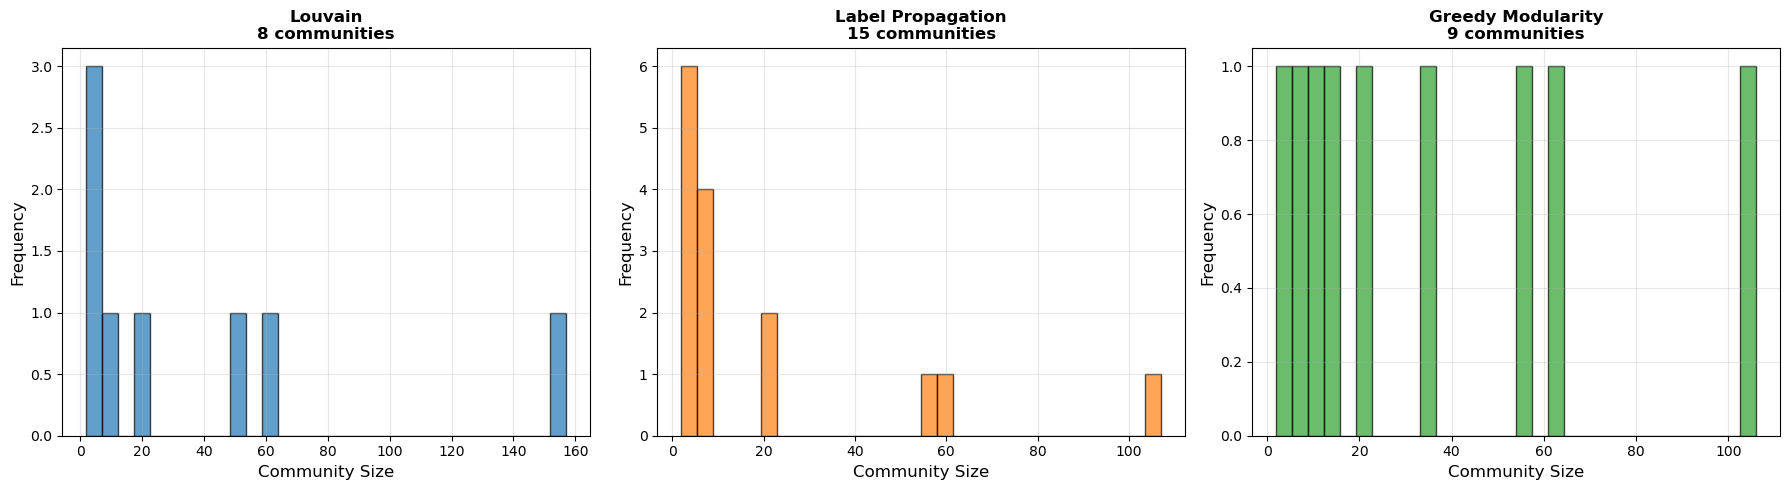

In [222]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sizes_louvain = [len(comm) for comm in communities_louvain.values()]
axes[0].hist(sizes_louvain, bins=30, edgecolor='black', alpha=0.7, color='#1f77b4')
axes[0].set_xlabel('Community Size', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'Louvain\n{len(communities_louvain)} communities', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)

sizes_lp = [len(comm) for comm in communities_lp]
axes[1].hist(sizes_lp, bins=30, edgecolor='black', alpha=0.7, color='#ff7f0e')
axes[1].set_xlabel('Community Size', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Label Propagation\n{len(communities_lp)} communities', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

sizes_greedy = [len(comm) for comm in communities_greedy]
axes[2].hist(sizes_greedy, bins=30, edgecolor='black', alpha=0.7, color='#2ca02c')
axes[2].set_xlabel('Community Size', fontsize=12)
axes[2].set_ylabel('Frequency', fontsize=12)
axes[2].set_title(f'Greedy Modularity\n{len(communities_greedy)} communities', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

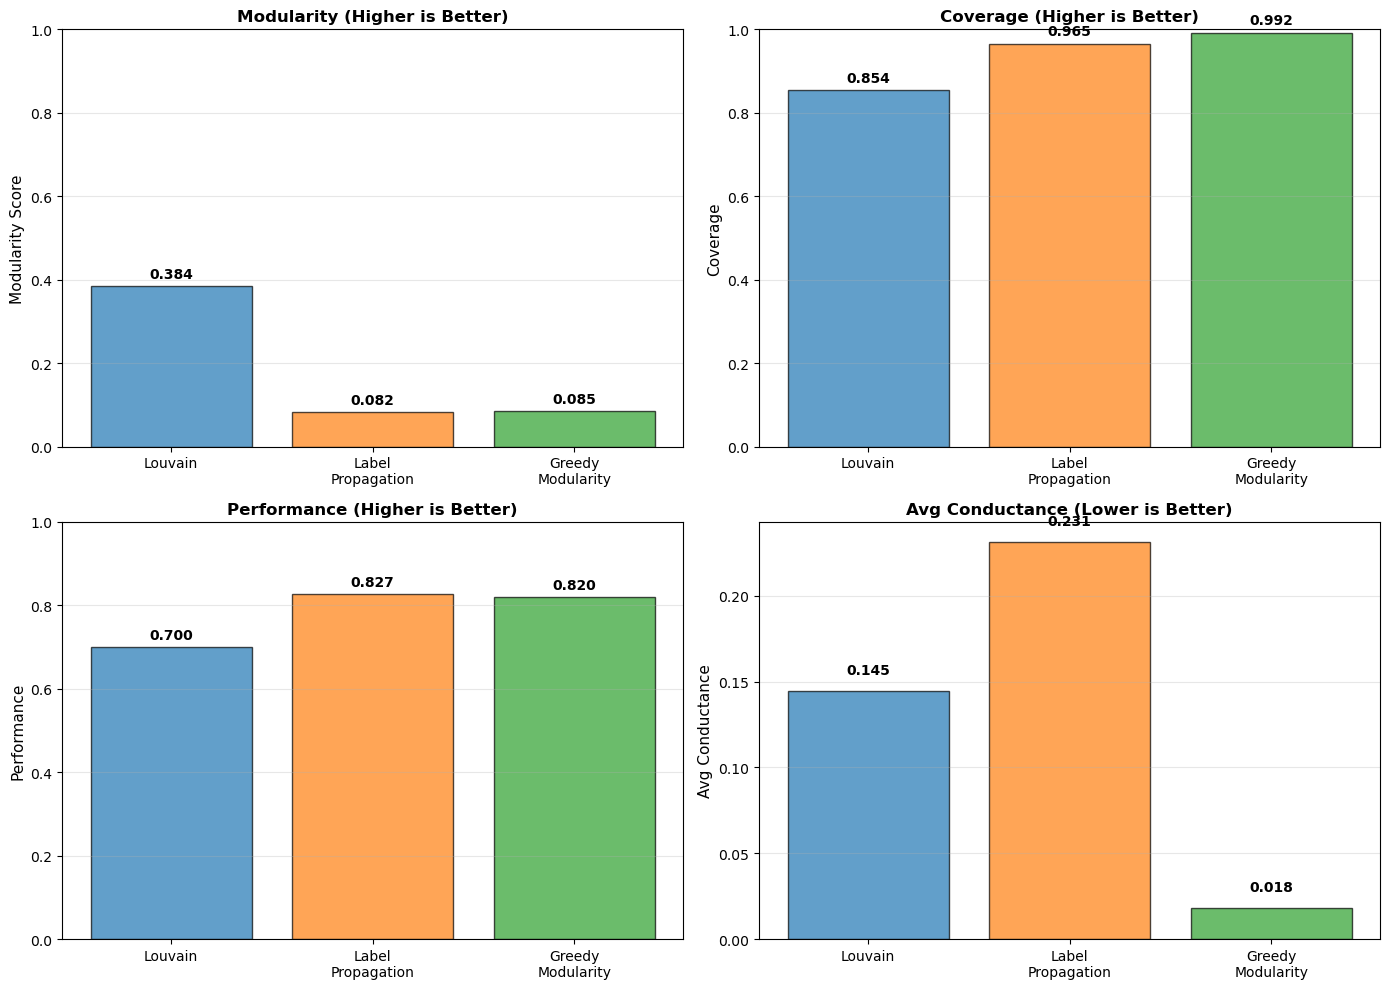

In [223]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

algorithms = ['Louvain', 'Label\nPropagation', 'Greedy\nModularity']
modularities = [results_df.loc[i, 'Modularity'] for i in range(3)]
coverages = [results_df.loc[i, 'Coverage'] for i in range(3)]
performances = [results_df.loc[i, 'Performance'] for i in range(3)]
conductances = [results_df.loc[i, 'Avg Conductance'] for i in range(3)]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

axes[0, 0].bar(algorithms, modularities, color=colors, alpha=0.7, edgecolor='black')
axes[0, 0].set_ylabel('Modularity Score', fontsize=11)
axes[0, 0].set_title('Modularity (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(modularities):
    axes[0, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[0, 1].bar(algorithms, coverages, color=colors, alpha=0.7, edgecolor='black')
axes[0, 1].set_ylabel('Coverage', fontsize=11)
axes[0, 1].set_title('Coverage (Higher is Better)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(coverages):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[1, 0].bar(algorithms, performances, color=colors, alpha=0.7, edgecolor='black')
axes[1, 0].set_ylabel('Performance', fontsize=11)
axes[1, 0].set_title('Performance (Higher is Better)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(performances):
    axes[1, 0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

axes[1, 1].bar(algorithms, conductances, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Avg Conductance', fontsize=11)
axes[1, 1].set_title('Avg Conductance (Lower is Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(conductances):
    axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()